In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define file paths
files = {
    "Metro_invt": "Metro_invt_fs_uc_sfr_month.csv",
    "Metro_median_sale_price": "Metro_median_sale_price_uc_sfrcondo_week.csv",
    "Metro_median_sale_to_list": "Metro_median_sale_to_list_uc_sfrcondo_week.csv",
    "Metro_mlp": "Metro_mlp_uc_sfr_month.csv",
    "Metro_zordi": "Metro_zordi_uc_sfr_month.csv",
    "National_zorf_growth": "National_zorf_growth_uc_sfr_sm_month.csv",
    "New_construction_sales": "New Construction Sales Count Raw SFR Month.csv"
}

# Load data into a dictionary with error handling
dataframes = {}
for key, path in files.items():
    try:
        dataframes[key] = pd.read_csv(path)
        print(f"Loaded '{key}' data successfully.")
    except FileNotFoundError:
        print(f"Error: File not found for '{key}' at path '{path}'. Please check the file path.")
    except pd.errors.EmptyDataError:
        print(f"Error: File for '{key}' is empty at path '{path}'.")
    except Exception as e:
        print(f"An error occurred while loading '{key}': {e}")

# loaded data
for key, df in dataframes.items():
    print(f"\nData preview for {key}:")
    print(df.head())
    

Loaded 'Metro_invt' data successfully.
Loaded 'Metro_median_sale_price' data successfully.
Loaded 'Metro_median_sale_to_list' data successfully.
Loaded 'Metro_mlp' data successfully.
Loaded 'Metro_zordi' data successfully.
Loaded 'National_zorf_growth' data successfully.
Loaded 'New_construction_sales' data successfully.

Data preview for Metro_invt:
   RegionID  SizeRank       RegionName RegionType StateName  2018-01-31  \
0    102001         0    United States    country       NaN   1206652.0   
1    394913         1     New York, NY        msa        NY     49048.0   
2    753899         2  Los Angeles, CA        msa        CA     16116.0   
3    394463         3      Chicago, IL        msa        IL     27301.0   
4    394514         4       Dallas, TX        msa        TX     22001.0   

   2018-02-28  2018-03-31  2018-04-30  2018-05-31  ...  2024-01-31  \
0   1224382.0   1339493.0   1416217.0   1483193.0  ...    757601.0   
1     52266.0     56865.0     63067.0     67191.0  ...  

In [2]:
# Define helper function to calculate monthly mortgage payment
def calculate_mortgage(principal, annual_rate, years):
    monthly_rate = annual_rate / 12
    payments = years * 12
    return (principal * monthly_rate) / (1 - (1 + monthly_rate) ** -payments)


In [3]:
# Define helper function to calculate monthly mortgage payment
def calculate_mortgage(principal, annual_rate, years):
    monthly_rate = annual_rate / 12
    payments = years * 12
    return (principal * monthly_rate) / (1 - (1 + monthly_rate) ** -payments)


In [4]:
# Define file paths
files = {
    "Metro_median_sale_price": "Metro_median_sale_price_uc_sfrcondo_week.csv",
    "Metro_zordi": "Metro_zordi_uc_sfr_month.csv",
}

In [5]:
# Load data into a dictionary with error handling
dataframes = {}
for key, path in files.items():
    try:
        dataframes[key] = pd.read_csv(path)
        print(f"Loaded '{key}' data successfully.")
    except FileNotFoundError:
        print(f"Error: File not found for '{key}' at path '{path}'. Please check the file path.")
    except pd.errors.EmptyDataError:
        print(f"Error: File for '{key}' is empty at path '{path}'.")
    except Exception as e:
        print(f"An error occurred while loading '{key}': {e}")

Loaded 'Metro_median_sale_price' data successfully.
Loaded 'Metro_zordi' data successfully.


In [6]:
# Assumptions
loan_rate = 0.05  # 5% annual interest rate
loan_term = 30  # 30 years loan
tax_rate = 0.01  # 1% annual property tax
upgrade_cost_percentage = 0.05  # 5% of median sale price

In [7]:
# Check if required datasets are loaded
if "Metro_median_sale_price" in dataframes and "Metro_zordi" in dataframes:
    # Extract datasets
    sale_price_data = dataframes["Metro_median_sale_price"]
    rental_income_data = dataframes["Metro_zordi"]

In [8]:
# Find possible merge keys
possible_keys = set(sale_price_data.columns).intersection(rental_income_data.columns)
if not possible_keys:
    raise KeyError("No common column found for merging the datasets. Ensure there is a common key in both datasets.")

merge_key = possible_keys.pop()


In [9]:
# Merge datasets
merged_data = pd.merge(sale_price_data, rental_income_data, on=merge_key, suffixes=("_sale", "_rent"))


In [10]:
# Check if required columns exist in the DataFrame
required_columns = ["median_sale_price", "median_rent"]
missing_columns = [col for col in required_columns if col not in merged_data.columns]

if missing_columns:
    # Add missing columns with default values (e.g., 0)
    for col in missing_columns:
        print(f"Column '{col}' is missing. Adding it with default values.")
        merged_data[col] = 0  # Replace with appropriate data-loading logic if needed

# Define helper function for calculating monthly costs
def calculate_monthly_cost(price, percentage):
    """Helper function to calculate monthly costs based on sale price and percentage."""
    return (price * percentage) / 12 if not pd.isna(price) else 0

# Calculate monthly mortgage, property tax, and upgrade costs
merged_data["Mortgage"] = merged_data["median_sale_price"].apply(
    lambda x: calculate_mortgage(x, loan_rate, loan_term) if not pd.isna(x) else 0
)

merged_data["Property_Tax"] = merged_data["median_sale_price"].apply(
    lambda x: calculate_monthly_cost(x, tax_rate)
)

merged_data["Upgrade_Cost"] = merged_data["median_sale_price"].apply(
    lambda x: calculate_monthly_cost(x, upgrade_cost_percentage)
)

# Calculate net income by subtracting costs from rent
merged_data["Net_Income"] = (
    merged_data["median_rent"].fillna(0)  # Replace missing rent values with 0
    - merged_data["Mortgage"]
    - merged_data["Property_Tax"]
    - merged_data["Upgrade_Cost"]
)

# Output the result for verification
print(merged_data.head())


Column 'median_sale_price' is missing. Adding it with default values.
Column 'median_rent' is missing. Adding it with default values.
   RegionID_sale  SizeRank_sale  RegionName_sale RegionType_sale  \
0         394910             47  New Orleans, LA             msa   
1         394910             47  New Orleans, LA             msa   
2         394910             47  New Orleans, LA             msa   
3         394910             47  New Orleans, LA             msa   
4         394910             47  New Orleans, LA             msa   

  StateName_sale  2008-02-02  2008-02-09  2008-02-16  2008-02-23  2008-03-01  \
0             LA         NaN         NaN         NaN         NaN         NaN   
1             LA         NaN         NaN         NaN         NaN         NaN   
2             LA         NaN         NaN         NaN         NaN         NaN   
3             LA         NaN         NaN         NaN         NaN         NaN   
4             LA         NaN         NaN         NaN     

In [11]:
# Check if the "Net_Income" column exists in the DataFrame
if "Net_Income" in merged_data.columns:
    # Calculate average monthly net income
    avg_monthly_net_income = merged_data["Net_Income"].mean()

    # Print the result
    print(f"The average monthly net rental income after upgrades, mortgage, and taxes is: ${avg_monthly_net_income:.2f}")
else:
    print("The 'Net_Income' column is missing in the dataset. Ensure calculations are performed correctly.")


The average monthly net rental income after upgrades, mortgage, and taxes is: $0.00


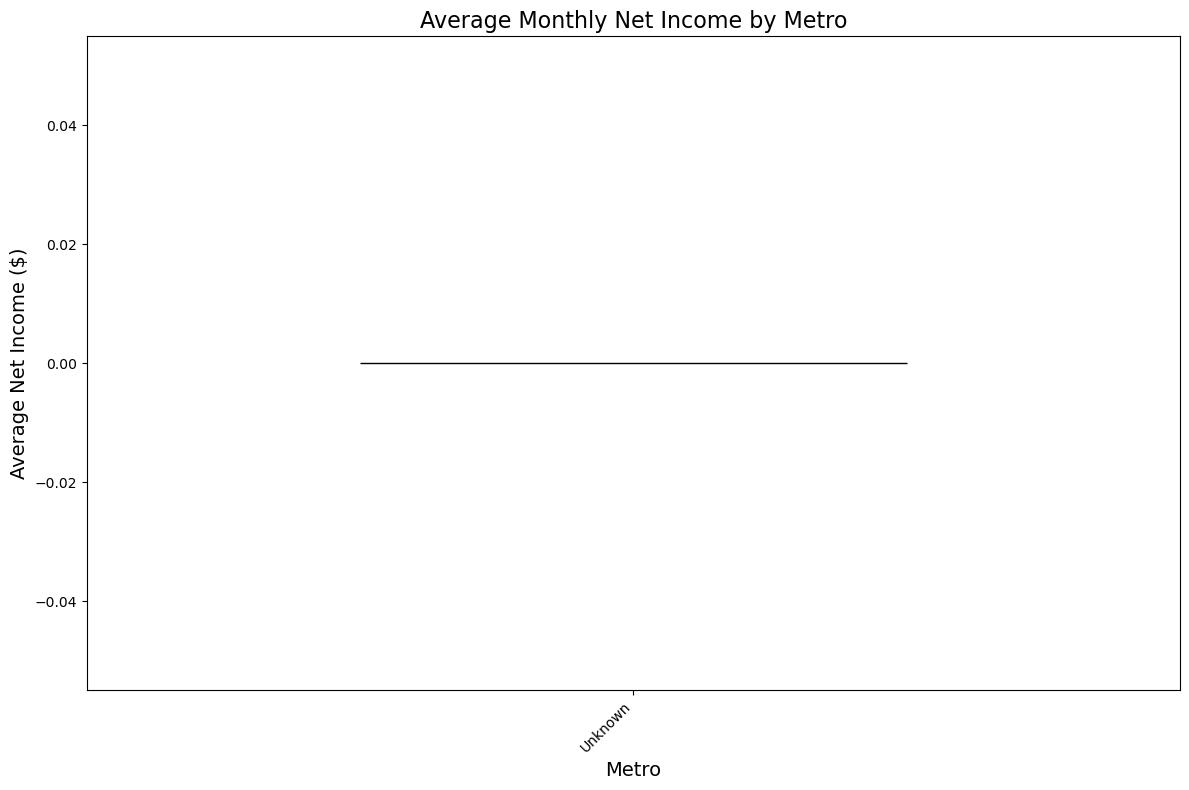

     Metro  Net_Income
0  Unknown         0.0
1  Unknown         0.0
2  Unknown         0.0
3  Unknown         0.0
4  Unknown         0.0


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Check if required columns exist in the DataFrame
required_columns = ["median_sale_price", "median_rent", "Mortgage", "Property_Tax", "Upgrade_Cost", "Net_Income", "Metro"]
missing_columns = [col for col in required_columns if col not in merged_data.columns]

# Handle missing columns
for col in missing_columns:
    if col == "median_sale_price":
        merged_data["median_sale_price"] = 0  # Replace with actual data if available
    elif col == "median_rent":
        merged_data["median_rent"] = 0  # Replace with actual data if available
    elif col == "Mortgage":
        merged_data["Mortgage"] = merged_data["median_sale_price"].apply(
            lambda x: calculate_mortgage(x, loan_rate, loan_term) if not pd.isna(x) else 0
        )
    elif col == "Property_Tax":
        merged_data["Property_Tax"] = merged_data["median_sale_price"].apply(
            lambda x: (x * tax_rate) / 12 if not pd.isna(x) else 0
        )
    elif col == "Upgrade_Cost":
        merged_data["Upgrade_Cost"] = merged_data["median_sale_price"].apply(
            lambda x: (x * upgrade_cost_percentage) / 12 if not pd.isna(x) else 0
        )
    elif col == "Net_Income":
        merged_data["Net_Income"] = (
            merged_data["median_rent"].fillna(0)
            - merged_data["Mortgage"]
            - merged_data["Property_Tax"]
            - merged_data["Upgrade_Cost"]
        )
    elif col == "Metro":
        merged_data["Metro"] = "Unknown"  # Replace with actual metro data if available

# Check if required columns exist for plotting
if "Net_Income" in merged_data.columns and "Metro" in merged_data.columns:
    # Group by 'Metro' and calculate average net income
    avg_net_income_by_metro = merged_data.groupby("Metro")["Net_Income"].mean().sort_values()

    # Plot the chart
    plt.figure(figsize=(12, 8))
    avg_net_income_by_metro.plot(kind="bar", color="skyblue", edgecolor="black")

    # Add labels and title
    plt.title("Average Monthly Net Income by Metro", fontsize=16)
    plt.xlabel("Metro", fontsize=14)
    plt.ylabel("Average Net Income ($)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    
    # Show the chart
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Net_Income' and 'Metro' are missing.")

# Output the first few rows of data for verification
print(merged_data[["Metro", "Net_Income"]].head())


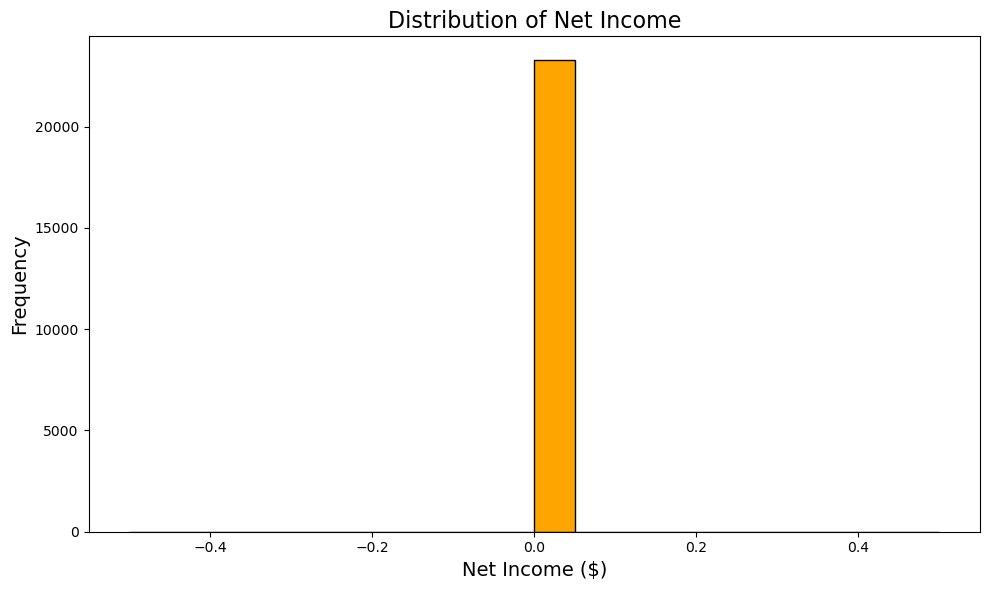

In [13]:
# Histogram of Net Income
if "Net_Income" in merged_data.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(merged_data["Net_Income"].dropna(), bins=20, color="orange", edgecolor="black")
    
    # Add labels and title
    plt.title("Distribution of Net Income", fontsize=16)
    plt.xlabel("Net Income ($)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    
    # Show the chart
    plt.tight_layout()
    plt.show()
else:
    print("The 'Net_Income' column is missing.")
